In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tt

def assemble_solve_SimplePDE(coeff):
  """
  Solve simple diffusion problem on [0,1] using P1 finite elements.
  """

  [num_coeff, nx, I] = np.shape(coeff)

  coeff = coeff[0,:,:]

  if np.min(coeff) <= 0:
    warnings.warn(f'Non positive components')
  
  A = []
  F = []
  U = []

  for i in range(I):
    F.append(np.full((nx-1,1), 1/(nx))) # assume RHS = 1 
    Ai = np.zeros((nx-1,nx-1))

    # assemble A, coeff piecewise constant on grid
    Ai.flat[::nx] = (coeff[1:,i] + coeff[:-1, i]) * nx # set diag
    Ai.flat[1::nx] = -coeff[1:-1,i] * nx # set first upper diag
    Ai.flat[nx-1::nx] = -coeff[1:-1,i] * nx # set first lowe diag
    A.append(Ai)
    U.append(np.linalg.solve(Ai, F[i]).reshape((-1,1)))

  return U,A,F


def coeff(X, Nx, Ny, offset, var):
  c = np.full(len(X), offset,dtype=float)
  for i, x in enumerate(X):
    # print(i)
    for k in range(1, len(x)):
      c[i] += np.exp(-k) * np.sin(np.pi*k*x[0]/(Nx-1)) * (x[k]/(Ny-1) - 0.5) * var
  return c

### PDE test

[0.045      0.08320466 0.11288338 0.13192847 0.13852066 0.13192847
 0.11288338 0.08320466 0.045     ]


Text(0, 0.5, 'C')

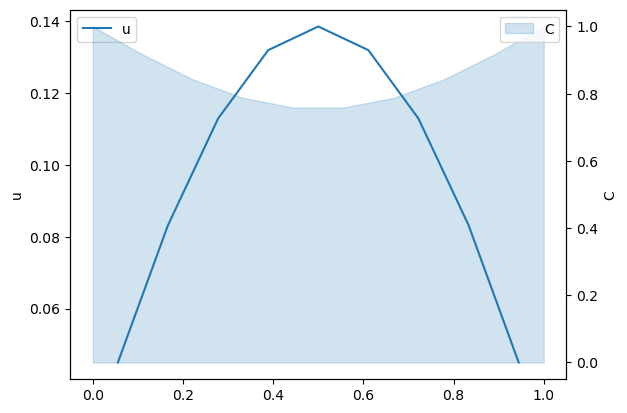

In [17]:
Nx = 10
Ny = 7
n_param = 1
offset = 1
var = 4

# get random params
#y = np.random.randint(0,Ny, n_param)
y = np.array([2])
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1])])

cfun = lambda x : coeff(x, Nx, Ny, offset, var)

C_true = cfun(X)

U,A,F = assemble_solve_SimplePDE(C_true.reshape(1,-1,1))
U = np.ravel(U)
print(U)

fig, ax = plt.subplots()
ax2 = ax.twinx()

p = ax.plot((np.arange(len(U))+0.5) / len(U), U, label='u')
ax2.fill_between(np.arange(len(C_true)) / (len(C_true) -1), C_true, alpha=0.2, color=p[0].get_color(), label='C')

ax.set_ylabel('u')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('C')

### Get TT approx of coefficient

In [18]:
from tt import cross

# random init tensor
C = tt.rand(np.array([Nx] + [Ny] * n_param),r=3)
# compute TT approx using TT-cross
C = tt.cross.rect_cross.cross(cfun, C, eps = 1e-12, kickrank=1)
C = C.round(1e-12)

print("Coefficient ranks: ", C.r)
print("Coefficient dims: ", C.n)

swp: 0/9 er_rel = 1.8e+00 er_abs = 1.6e+01 erank = 5.0 fun_eval: 136
swp: 1/9 er_rel = 3.9e-16 er_abs = 3.4e-15 erank = 7.0 fun_eval: 354
Coefficient ranks:  [1 2 1]
Coefficient dims:  [10  7]


### Test TT approx

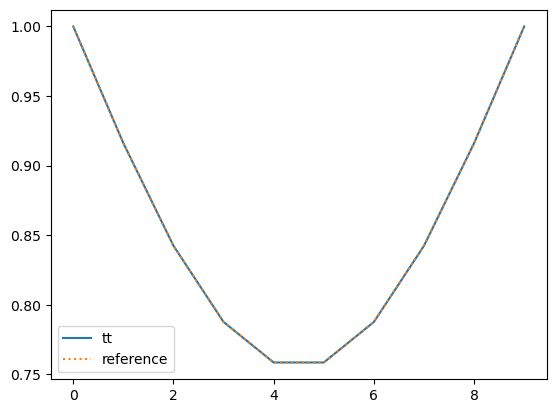

In [19]:
# eval TT-approx of coeff
C_eval = np.empty(Nx)
for i in range(Nx):
  C_eval[i] = C[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

ax.plot(C_eval, label='tt')
ax.plot(C_true, ls='dotted', label="reference")

ax.legend()

### ALS-cross test

In [38]:
import als_cross_parametric as alscr
import importlib
importlib.reload(alscr)
import numpy

u, time, funevals = alscr.als_cross_parametric(C, assemble_solve_SimplePDE, 0e-8, nswp=1,kickrank=0,random_init=0)

print(f"solve: {time[0]}s, project: {time[1]}s")
print(f"function eval: {funevals}")

u_list = tt.tensor.to_list(u)

norm = [numpy.linalg.norm(u.flatten()) for u in u_list]

print(norm)
print(u_list[0])

err_c = 1.8299454293093485e-15
Ci
[[[1.         1.        ]
  [1.25164436 0.74835564]
  [1.47293669 0.52706331]
  [1.63718588 0.36281412]
  [1.72458105 0.27541895]
  [1.72458105 0.27541895]
  [1.63718588 0.36281412]
  [1.47293669 0.52706331]
  [1.25164436 0.74835564]
  [1.         1.        ]]]
=als_cross_parametric= 0 swp=1, max_dx=1.000e+00, max_rank = 2
U0
[[0.045      0.045     ]
 [0.07296321 0.09176921]
 [0.08993611 0.13920184]
 [0.09909817 0.18054532]
 [0.10199743 0.19869949]
 [0.09909817 0.18054532]
 [0.08993611 0.13920184]
 [0.07296321 0.09176921]
 [0.045      0.045     ]]
cru shape = 14 1
=als_cross_parametric= swp=1 (1), i=1, dx=1.000e+00, rank =[2, 1]
solve: 0.00131486000464065s, project: 0.00035408300027484074s
function eval: 2
[1.4142135623730951, 0.8144371453813447]
[[[-0.1823213  -0.39456515]
  [-0.29561663 -0.37267711]
  [-0.36438375 -0.0889244 ]
  [-0.40150462  0.28776504]
  [-0.4132512   0.47898612]
  [-0.40150462  0.28776504]
  [-0.36438375 -0.0889244 ]
  [-0.2956166

### Test ALS-cross accuracy

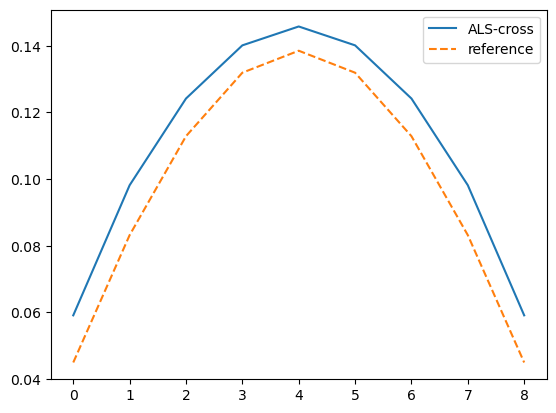

In [39]:
# get random parameter
#y = np.random.randint(0,Ny, n_param)
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1])])

C_true = cfun(X) # compute true coeff

U,A,F = assemble_solve_SimplePDE(C_true.reshape(1,-1,1)) # solve PDE
U = np.ravel(U)

# eval ALS-cross
U_eval = np.empty(u.n[0])
for i in range(u.n[0]):
  U_eval[i] = u[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

ax.plot(U_eval,label='ALS-cross')
ax.plot(U, ls='dashed', label='reference')
ax.legend()